In [1]:
from transformers import AutoImageProcessor, DetrForObjectDetection
import torch
from PIL import Image

image_processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")


/home/john/dev/ai-osint-tracker/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/home/john/dev/ai-osint-tracker/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:2409: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warning

In [ ]:
file = "road.png"
image = Image.open(file).convert("RGB")

inputs = image_processor(images=image, return_tensors="pt")
outputs = model(**inputs)

In [6]:
# convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[
    0
]
print(results["scores"])
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

tensor([0.9813, 0.9534, 0.9993], grad_fn=<IndexBackward0>)
Detected car with confidence 0.981 at location [672.69, 666.32, 755.21, 712.16]
Detected car with confidence 0.953 at location [1253.09, 451.28, 1305.71, 487.7]
Detected car with confidence 0.999 at location [1068.06, 1130.5, 1277.44, 1319.49]


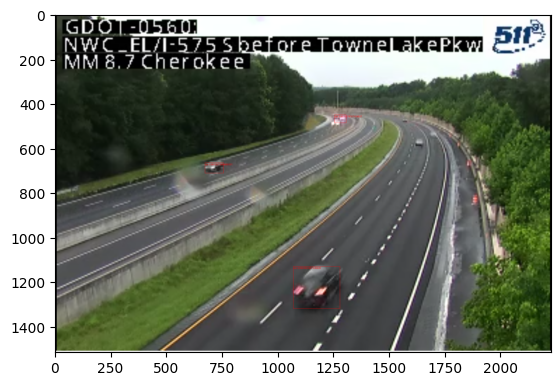

In [ ]:
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plot

image = read_image(file)
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_boxes = results["boxes"].long()
labels = [f"{model.config.id2label[label.item()]}: {score} " for label, score in zip(results["labels"], results["scores"])]
output_image = draw_bounding_boxes(image, pred_boxes, labels, colors="red")

plot.imshow(output_image.permute(1, 2, 0))
plot.show()

['car', 'car', 'car']